In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [12]:
# Define the input directory containing WSIs and output directories
input_dir = "../data/raw/wsi_folder"  # Update with the path to your folder containing WSIs
patch_output_dir = "../data/processed/extracted_patches_grid"
labeled_image_dir = "../data/processed/WSI_transformed_images"
os.makedirs(patch_output_dir, exist_ok=True)
os.makedirs(labeled_image_dir, exist_ok=True)

In [13]:
print(f"Files in '{input_dir}':")
for filename in os.listdir(input_dir):
    # Check if it's a file (and not a directory)
    file_path = os.path.join(input_dir, filename)
    if os.path.isfile(file_path):
        print(filename)

Files in '..\data\raw\wsi_folder':
open_wsi - Copy (2).jpg
open_wsi - Copy (3).jpg
open_wsi - Copy (4).jpg
open_wsi - Copy.jpg
open_wsi.jpg


In [14]:
# Define the patch size and the threshold for mask coverage
patch_size = 50
coverage_threshold = 0.03 # change this if small parts are missing from segmentation

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.6
font_thickness = 2
font_color = (0, 0, 255)  # Red text

Processed and saved patches for open_wsi - Copy (2).jpg
Processed and saved patches for open_wsi - Copy (3).jpg
Processed and saved patches for open_wsi - Copy (4).jpg
Processed and saved patches for open_wsi - Copy.jpg
Processed and saved patches for open_wsi.jpg


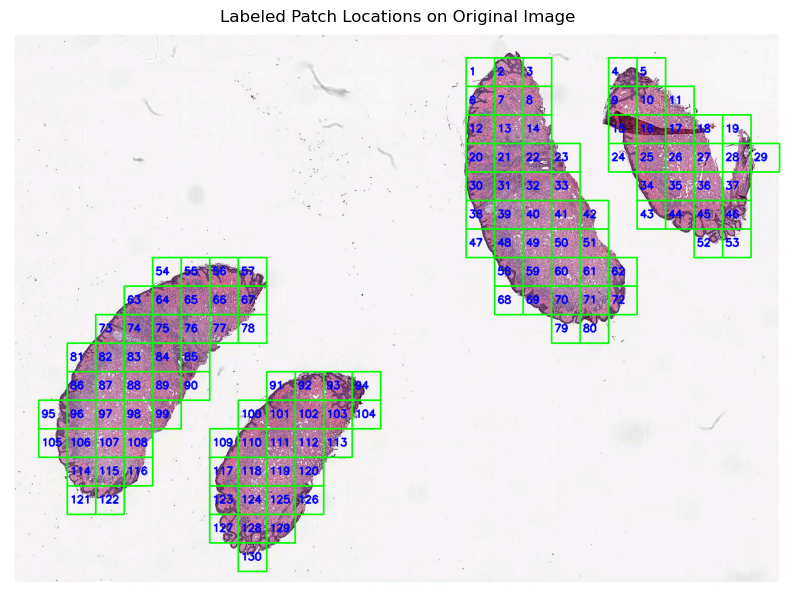

In [15]:
# Process each WSI in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):  # Add other extensions if needed
        image_path = os.path.join(input_dir, filename)
        
        # Load the WSI
        image_rgb = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed
        
        # Generate the thresholding mask
        gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        _, threshold_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((5, 5), np.uint8)
        threshold_mask = cv2.morphologyEx(threshold_mask, cv2.MORPH_CLOSE, kernel)
        threshold_mask = cv2.morphologyEx(threshold_mask, cv2.MORPH_OPEN, kernel)

        # Generate the edge mask using Canny
        edges_canny = cv2.Canny(gray_image, threshold1=100, threshold2=200)

        # Resize the edge mask to match the threshold mask size
        edges_canny_resized = cv2.resize(edges_canny, (threshold_mask.shape[1], threshold_mask.shape[0]))

        # Combine the masks using a weighted sum
        alpha = 0.4  # Weight for the threshold mask
        beta = 0.2   # Weight for the edge mask
        combined_mask = cv2.addWeighted(threshold_mask.astype(float), alpha, edges_canny_resized.astype(float), beta, 0.0)

        # Threshold the combined mask to create a final binary mask
        _, final_mask = cv2.threshold(combined_mask, 127, 255, cv2.THRESH_BINARY)
        
        # Extract the original image name without extension
        image_name = os.path.splitext(filename)[0]
        
        # Create a copy of the original image for visualization
        image_with_patches = image_rgb.copy()
        
        # Initialize patch number counter
        patch_number = 1
        
        # Grid-based patch extraction
        for row in range(0, image_rgb.shape[0], patch_size):
            for col in range(0, image_rgb.shape[1], patch_size):
                # Define the patch area
                patch_mask = final_mask[row:row + patch_size, col:col + patch_size]
                patch_image = image_rgb[row:row + patch_size, col:col + patch_size]

                # Check the number of non-black pixels in the mask
                non_black_pixels = np.sum(patch_mask > 0)
                total_pixels = patch_size * patch_size
                
                # Calculate coverage
                coverage = non_black_pixels / total_pixels

                if coverage >= coverage_threshold:
                    # Save the patch with filename containing number and grid location
                    patch_filename = os.path.join(patch_output_dir, f"{image_name}_patch_{patch_number}_x{col}_y{row}.png")
                    cv2.imwrite(patch_filename, cv2.cvtColor(patch_image, cv2.COLOR_RGB2BGR))
                    
                    # Draw a rectangle on the visualization image
                    cv2.rectangle(image_with_patches, (col, row), (col + patch_size, row + patch_size), (0, 255, 0), 2)
                    
                    # Overlay the patch number on the visualization image
                    text = f"{patch_number}"
                    text_position = (col + 5, row + 30)
                    cv2.putText(image_with_patches, text, text_position, font, font_scale, font_color, font_thickness)
                    
                    # Increment the patch number
                    patch_number += 1
        
        # Save the labeled image with patch locations
        labeled_image_filename = f"{image_name}_patch_locations.png"
        labeled_image_path = os.path.join(labeled_image_dir, labeled_image_filename)
        cv2.imwrite(labeled_image_path, cv2.cvtColor(image_with_patches, cv2.COLOR_RGB2BGR))
        
        print(f"Processed and saved patches for {filename}")

# Optionally, display the last processed image with patch locations and labels
plt.figure(figsize=(10, 10))
plt.imshow(image_with_patches)
plt.title('Labeled Patch Locations on Original Image')
plt.axis('off')
plt.show()